## Importance and SHAP values

In this Jupyter Notebook, we will

### Feature Importance

We will start with feature importance.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

We'll start with the _iris_ data.

In [4]:

# Load sample dataset (Iris Dataset for classification)
data = load_iris()
X = data.data
y = data.target

In [5]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset for models that are sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),  # Linear SVM for simplicity
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(random_state=42)
}

In [8]:

# Function to calculate feature importance for each classifier
def calculate_feature_importance(classifiers, X_train, y_train):
    importance_results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        
        if name == "Decision Tree":
            importance_results[name] = clf.feature_importances_
        
        elif name == "Logistic Regression":
            # Coefficients of Logistic Regression (scaled by regularization)
            importance_results[name] = np.abs(clf.coef_[0])
        
        elif name == "SVM":
            # SVM uses the absolute value of coefficients as feature importance
            importance_results[name] = np.abs(clf.coef_[0]) if hasattr(clf, 'coef_') else None
        
        elif name == "LDA":
            # For LDA, the absolute values of the coefficients are used to determine importance
            importance_results[name] = np.abs(clf.coef_[0])
    
    return importance_results

# Calculate feature importance
importance_values = calculate_feature_importance(classifiers, X_train_scaled, y_train)


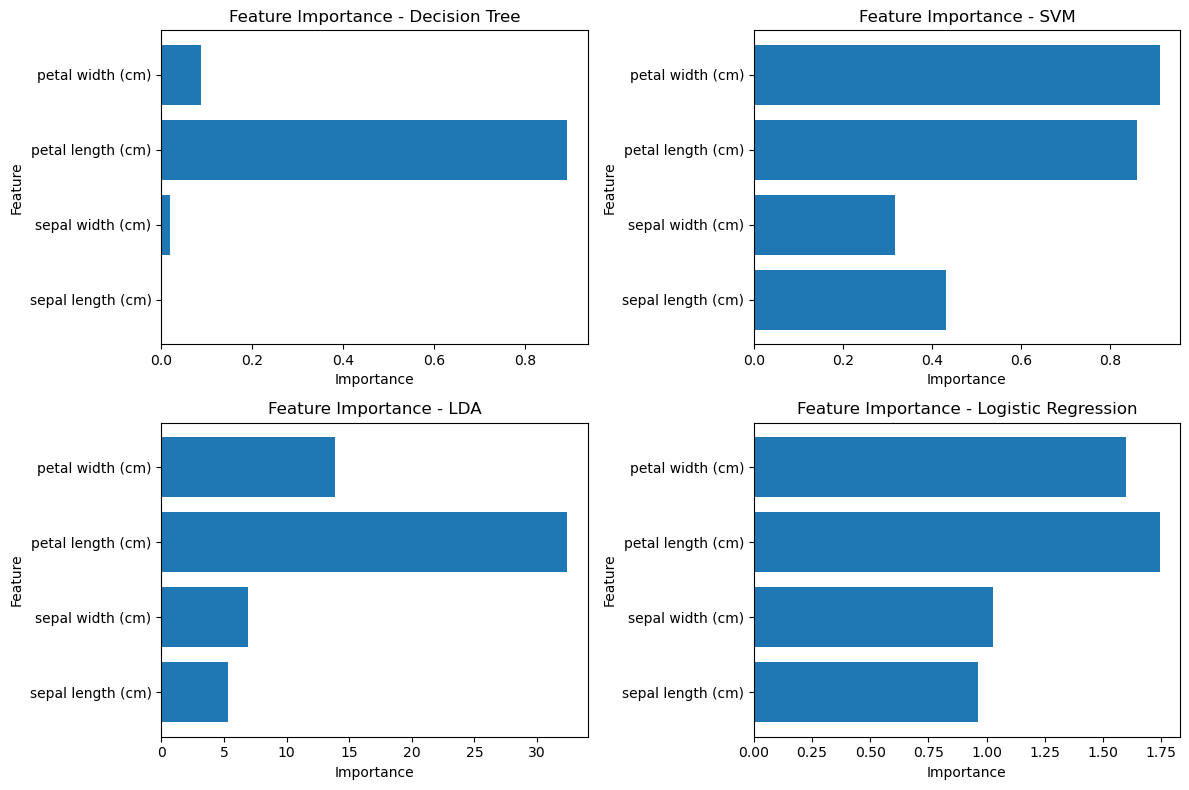

In [9]:


# Plot feature importance
def plot_feature_importance(importance_values, feature_names):
    plt.figure(figsize=(12, 8))
    
    for i, (name, importance) in enumerate(importance_values.items()):
        plt.subplot(2, 2, i+1)
        plt.barh(feature_names, importance)
        plt.title(f'Feature Importance - {name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')

    plt.tight_layout()
    plt.show()

# Feature names from the Iris dataset
feature_names = data.feature_names

# Plotting the feature importances
plot_feature_importance(importance_values, feature_names)



Above we can see the impact of the four features on these four models types.  

For the decision tree model, clearly petal length is the most important feature.  For SVM, petal 
length and petal width seem to be more important than sepal width and sepal length.  For LDA, petal length is more important than petal width which is more important that sepal width which is more important than sepal length.  Finally, all of the features seem relatively important for the logistic regression with petal length being the most important.

In [10]:
# read in the bcancer data
bcancer = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/BreastCancer.csv", na_values=['NA'])
bcancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Diagnosis       569 non-null    object 
 1   Radius          569 non-null    float64
 2   Texture         569 non-null    float64
 3   Perimeter       569 non-null    float64
 4   Area            569 non-null    float64
 5   Smoothness      569 non-null    float64
 6   Compactness     569 non-null    float64
 7   Concavity       569 non-null    float64
 8   Concave Points  569 non-null    float64
 9   Symmetry        569 non-null    float64
dtypes: float64(9), object(1)
memory usage: 44.6+ KB


In [11]:
X=bcancer[['Radius', 'Texture','Perimeter','Area','Smoothness']]

y=bcancer['Diagnosis']
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset for models that are sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Classifiers

In [12]:

# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),  # Linear SVM for simplicity
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(random_state=42)
}

In [13]:
# Calculate feature importance
importance_values = calculate_feature_importance(classifiers, X_train_scaled, y_train)

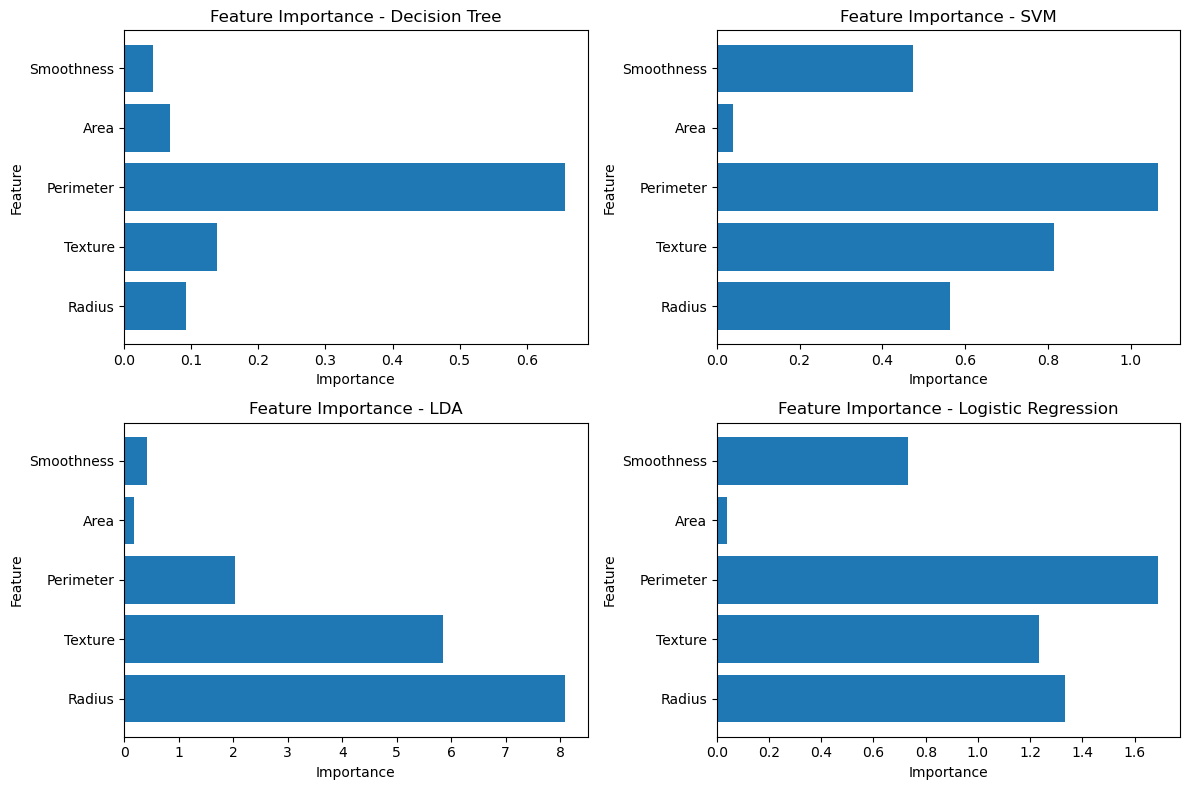

In [14]:
# Feature names from the Iris dataset
feature_names = ['Radius', 'Texture','Perimeter','Area','Smoothness']

# Plotting the feature importances
plot_feature_importance(importance_values, feature_names)

## 🔍 Evaluating Classifiers Using Accuracy Scores

In [18]:
from sklearn.metrics import accuracy_score
 
# Dictionary to store accuracy scores
accuracy_scores = {}

# Loop through classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)  # Train the classifier
    y_pred = clf.predict(X_test_scaled)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Correct function call
    accuracy_scores[name] = accuracy  # Store accuracy

# Print accuracy results
for model, acc in accuracy_scores.items():
    print(f"{model}: {acc:.4f}")

Decision Tree: 0.9123
SVM: 0.9240
LDA: 0.9415
Logistic Regression: 0.9240


### SHAP

The SHAP approach to determining the impact of a feature is to 
consider at all possible combinations of features and how the prediction would change 
if a feature were included or excluded. 


In [49]:
#### !!!! you likely have to install shap
# Try pip3 install shap
######
# If that doesn't work try pip3 install shap --pre
import shap

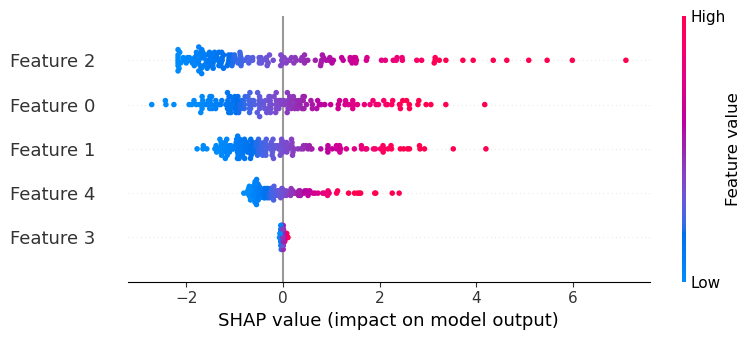

In [50]:
# Train the Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train_scaled)

# Get SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot the SHAP summary plot (global explanation of the model)
shap.summary_plot(shap_values, X_test)

The order of impact for these features seems to be 2, 0, 7, 1, 8, and 4 followed by 5, 3 and 6.  The latter three seems to have a good bit less impact than the former six.  Recall that the order of the 
feature names was ['Radius', 'Texture','Perimeter','Area','Smoothness','Compactness','Concavity','Concave Points','Symmetry'], so that Perimeter, feature 2, would be the most impactful here.

### Display the SHAP

.values =
array([[-2.71322201e-01, -4.03600968e-01, -2.72579254e-01,
        -7.04303831e-04, -1.38031059e-01],
       [ 7.59927219e-01,  1.06881817e+00,  1.10441739e-01,
        -5.08859518e-02,  5.32320930e-01],
       [ 2.05252106e-01,  2.02996640e-01,  6.39408120e-01,
        -3.24530000e-02, -4.14007953e-03],
       [-2.82479459e-01, -4.35634774e-01, -3.08757265e-01,
         3.94080003e-02, -2.03743047e-01],
       [-4.19554343e-01, -5.83081159e-01, -4.46343339e-01,
         2.18004045e-02, -3.32924294e-01],
       [ 1.02451362e+00,  1.37552483e+00,  3.44594477e+00,
         3.46759589e-02,  5.96463007e-01],
       [ 1.24925268e+00,  1.86852738e+00,  1.98512052e+00,
        -1.35248345e-02,  9.97687400e-01],
       [ 5.41563741e-01,  6.71462658e-01, -1.63183388e-02,
        -1.30296209e-02,  3.45950069e-01],
       [-1.32653422e-01, -3.17041534e-01,  2.32405490e-01,
         2.84032529e-02, -3.53781682e-01],
       [-4.33953581e-02, -1.36652583e-01, -1.06479548e+00,
        -4.67

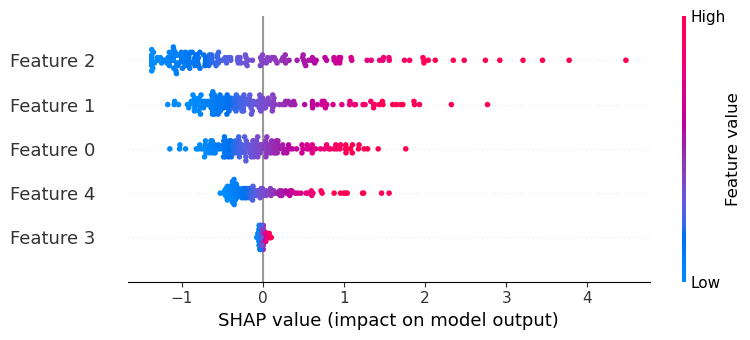

In [51]:
# Train the Support Vector Machine Classifier
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train_scaled)

# Get SHAP values for the test set
shap_values = explainer(X_test_scaled)
print(shap_values)
# Plot the SHAP summary plot (global explanation of the model)
shap.summary_plot(shap_values, X_test)


For the above plot, we can see that feature 2, 0, 1, 7, and 8 seem to be important with positive relationships with the response.  Features 5, 6, and 3 seem to have less impact with Features 5 and 3 having a negative relationship with our response here.

### Tasks

1. Choose one of the model types from the Feature Importance section above and fit the model with all of the predictors.  Assess that model for cross-validation accuracy.


In [52]:
from sklearn.model_selection import cross_val_score

# fit the model for SVM
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

# assess the model using cross-validation
cv_results = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Accuracy:", cv_results.mean())

Cross-Validation Accuracy: 0.901993670886076


### feature importance with one classifier
2. For the model you chose in the previous task, look at the Feature Importance plot and remove some of the variables from the full model in the previous task.  Fit this new smaller model and assess that model using cross-validation.  Was the cross-validation accuracy an improvement.


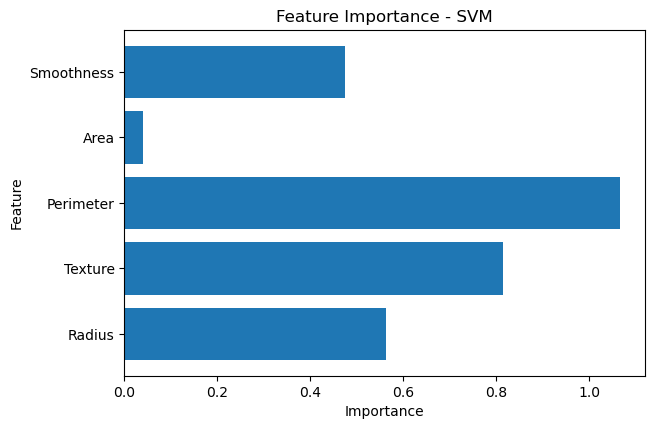

In [ ]:
classifiers = {   
    "SVM": SVC(kernel='linear', random_state=42),  # Linear SVM for simplicity
       }
# calculate and plot feature importance for SVM
# set feature names
feature_names = ['Radius', 'Texture','Perimeter','Area','Smoothness']
importance_values = calculate_feature_importance(classifiers, X_train_scaled, y_train)
plot_feature_importance(importance_values, feature_names)


3.  Get the SHAP values for the features in a linear discriminant analysis.  


.values =
array([[-2.71322201e-01, -4.03600968e-01, -2.72579254e-01,
        -7.04303831e-04, -1.38031059e-01],
       [ 7.59927219e-01,  1.06881817e+00,  1.10441739e-01,
        -5.08859518e-02,  5.32320930e-01],
       [ 2.05252106e-01,  2.02996640e-01,  6.39408120e-01,
        -3.24530000e-02, -4.14007953e-03],
       [-2.82479459e-01, -4.35634774e-01, -3.08757265e-01,
         3.94080003e-02, -2.03743047e-01],
       [-4.19554343e-01, -5.83081159e-01, -4.46343339e-01,
         2.18004045e-02, -3.32924294e-01],
       [ 1.02451362e+00,  1.37552483e+00,  3.44594477e+00,
         3.46759589e-02,  5.96463007e-01],
       [ 1.24925268e+00,  1.86852738e+00,  1.98512052e+00,
        -1.35248345e-02,  9.97687400e-01],
       [ 5.41563741e-01,  6.71462658e-01, -1.63183388e-02,
        -1.30296209e-02,  3.45950069e-01],
       [-1.32653422e-01, -3.17041534e-01,  2.32405490e-01,
         2.84032529e-02, -3.53781682e-01],
       [-4.33953581e-02, -1.36652583e-01, -1.06479548e+00,
        -4.67

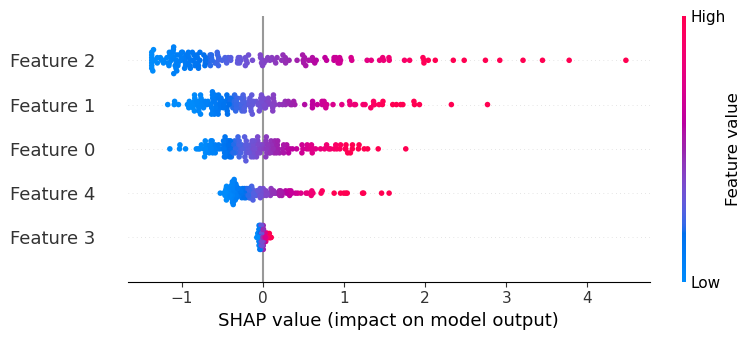

In [56]:

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train_scaled)

# Get SHAP values for the test set
shap_values = explainer(X_test_scaled)
print(shap_values)
# Plot the SHAP summary plot (global explanation of the model)
shap.summary_plot(shap_values, X_test)


4. Using the output you got from the previous task, create a reduced model with fewer predictors and evaluate that model via cross-validation.

In [58]:
# create a reduced model with fewer features
X_train_reduced = X_train[['Perimeter', 'Area', 'Smoothness']]
X_test_reduced = X_test[['Perimeter', 'Area', 'Smoothness']]
model_reduced = SVC(kernel='linear')
model_reduced.fit(X_train_reduced, y_train)

# evaluate the reduced model using cross-validation
cv_results_reduced = cross_val_score(model_reduced, X_train_reduced, y_train, cv=5)
print("Cross-Validation Accuracy (reduced model):", cv_results_reduced.mean())

Cross-Validation Accuracy (reduced model): 0.8365822784810126
